In [1]:
import sys
sys.path.append('../modules')

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import control_theory as ct
from lqr_rl import *
%matplotlib inline

In [2]:
gamma = 1
A = np.array([[0.8091,0.8996,0.8629],[0.3025,0.2493,0.9991],[0.1081,0.5432,0.4614]])
B = np.array([[1,0],[0,1],[0,1]])
ctrb = ct.ctrb(A,B)
print(ct.rank(ctrb))

3


In [29]:
n,p = B.shape
n_th = int((n+p)*(n+p+1)/2)

E = np.eye(n)
F = np.eye(p)

iter_RLS = 1000
iter_Gain = 50
s_n = 10

U_opt = - lqr(A,B,E,F)[1]

x_hist = []
U_hist = []
Uerr_hist = []

In [30]:
while True:
    theta = np.random.randn(n_th,)
    H = theta_to_H(theta,n+p)
    U = - np.dot(np.linalg.inv(H[n:n+p,n:n+p]), H[n:n+p,0:n])
    if max(np.abs(np.linalg.eig(A+np.dot(B,U))[0]))<0.99:
        break

print('initial gain')
print(U)

x = np.random.rand(n,)/10;
P = np.eye(n_th)

for k in range(1,iter_Gain+1):
    Uerr_hist.append(np.linalg.norm(U-U_opt, ord='fro'))
    for i in range(1,iter_RLS+1):
        u = np.dot(U,x) + np.random.randn(p,)*s_n
        c = quad(x,E) + quad(u,F)
        bar = H_to_theta(np.outer(np.hstack((x,u)),np.hstack((x,u))))
        x = np.dot(A,x) + np.dot(B,u)
        u = np.dot(U,x)
        barplus = H_to_theta(np.outer(np.hstack((x,u)),np.hstack((x,u))))
        
        phi = bar - np.dot(gamma, barplus)
        
        e = c - np.dot(phi,theta)
        denom = 1 + quad(phi,P)
        theta += np.dot(np.dot(P,phi),e)/denom
        P -= np.outer(np.dot(P,phi),np.dot(phi,P))/denom

    H = theta_to_H(theta,n+p)
    U = - np.dot(np.linalg.inv(H[n:n+p,n:n+p]), H[n:n+p,0:n])
    if max(np.abs(np.linalg.eig(A+np.dot(B,U))[0]))>1:
        print(k)
        break
print('final gain')
print(U)

initial gain
[[-0.65126075  0.15912718 -1.0751276 ]
 [ 0.08056936 -0.88674707 -0.68550919]]
final gain
[[-0.46004028 -0.54472213 -0.52067491]
 [-0.22746831 -0.40178346 -0.65856366]]


Optimal Gain
[[-0.46167044 -0.53511038 -0.5279651 ]
 [-0.22785121 -0.40611603 -0.65336881]]


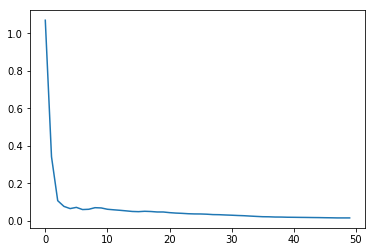

In [31]:
print('Optimal Gain')
print(U_opt)
plt.plot(Uerr_hist)
plt.show()

In [ ]:
def quad(X,A):
    """ Returns X.T*A*X
    """
    assert A.shape[1] == X.shape[0], 'Dimension Error'
    tmp = np.dot(np.dot(X.T,A),X)
    return tmp

In [3]:
#Dynamic Programming
n,p = B.shape
n_th = int((n+p)*(n+p+1)/2)
E = np.eye(n)
F = np.eye(p)
U_opt = - lqr(A,B,E,F)[1]

initial_gain = initialGain(A,B,E,F)[0]
dpagent = DpAgent(A,B,E,F,initial_gain)
dpagent.fit(iter_Gain=50)
print('initial gain')
print(initial_gain)
print('final gain')
print(dpagent.final_gain)
print('optimal gain')
print(U_opt)

KeyboardInterrupt: 

In [4]:
#RL usin module
n,p = B.shape
n_th = int((n+p)*(n+p+1)/2)
E = np.eye(n)
F = np.eye(p)
U_opt = - lqr(A,B,E,F)[1]

initial_gain, theta = initialGain(A,B,E,F)
rlagent = RlAgent(A,B,E,F,initial_gain=initial_gain,theta=theta)
rlagent.fit()
print('initial gain')
print(initial_gain)
print('final gain')
print(rlagent.final_gain)
print('optimal gain')
print(U_opt)

KeyboardInterrupt: 

In [14]:
#difference between RL and DP
n,p = B.shape
n_th = int((n+p)*(n+p+1)/2)
E = np.eye(n)
F = np.eye(p)
U_opt = - lqr(A,B,E,F)[1]

initial_gain, theta = initialGain(A,B,E,F)
rlagent = RlAgent(A,B,E,F,initial_gain=initial_gain,theta=theta)
rlagent.fit()
dpagent = DpAgent(A,B,E,F,initial_gain=initial_gain)
dpagent.fit(iter_Gain=50)
print('initial gain')
print(initial_gain)
print('final gain of RL')
print(rlagent.final_gain)
print('final gain of DP')
print(dpagent.final_gain)
print('optimal gain')
print(U_opt)

initial gain
[[-0.76997943 -0.6543132  -0.78870169]
 [ 0.60899261  0.17455866 -1.00076236]]
final gain of RL
[[-0.51631205 -0.63159821 -0.54062718]
 [-0.20454295 -0.39843372 -0.64846643]]
final gain of DP
[[-0.46167044 -0.53511038 -0.5279651 ]
 [-0.22785121 -0.40611603 -0.65336881]]
optimal gain
[[-0.46167044 -0.53511038 -0.5279651 ]
 [-0.22785121 -0.40611603 -0.65336881]]


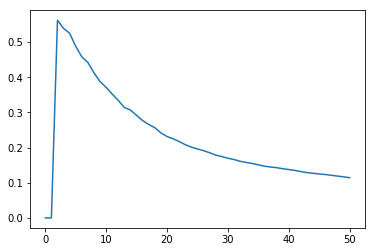

In [15]:
dlist = []
for i in range(len(rlagent.U_hist)):
    rlU = rlagent.U_hist[i]
    dpU = dpagent.U_hist[i]
    dif = np.linalg.norm(rlU-dpU, ord='fro')
    dlist.append(dif)
plt.plot(dlist)
plt.show()

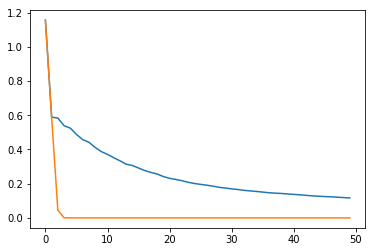

In [18]:
plt.plot(rlagent.Uerr_hist)
plt.plot(dpagent.Uerr_hist)
plt.show()